## predicting Oscar winner_ modeling(best)

### 부문별 모델 생성
## 1. 작품상

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 


### 데이터 불러오기 및 전처리

In [5]:
final_best = pd.read_csv("./data/final_best.csv")
final_best.drop("Documentary", axis =1, inplace =True) # 다큐멘터리 장르는 없으므로 의미없는 칼럼, 삭제한다.
final_best = pd.concat([final_best,pd.get_dummies(final_best['Date'])], axis=1) # Date 칼럼 원핫인코딩
final_best['win'] = final_best['win'].apply(lambda x : 1 if (x == True) else 0) # win 컬럼 01 변환
final_best.head()

,year_film,year_ceremony,ceremony,category,name,film,win,Gross,Date,Runtime,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1976,1977,49,BEST PICTURE,Walter Coblenz Producer,All the Presidents Men,0,7.060000e+07,Apr,138,...,0,0,0,0,0,0,0,0,0,0
1,1976,1977,49,BEST PICTURE,Robert F Blumofe and Harold Leventhal Producers,Bound for Glory,0,5.986694e+07,Dec,147,...,1,0,0,0,0,0,0,0,0,0
2,1976,1977,49,BEST PICTURE,Howard Gottfried Producer,Network,0,2.368988e+07,Nov,121,...,0,0,0,0,0,0,0,1,0,0
3,1976,1977,49,BEST PICTURE,Irwin Winkler and Robert Chartoff Producers,Rocky,1,1.172351e+08,Dec,120,...,1,0,0,0,0,0,0,0,0,0
4,1976,1977,49,BEST PICTURE,Michael Phillips and Julia Phillips Producers,Taxi Driver,0,2.826257e+07,Feb,114,...,0,1,0,0,0,0,0,0,0,0


### Train_data, Train_label 분리

In [6]:
train_data = final_best.drop(["win","year_film","year_ceremony","ceremony","category","name","film","Date"],axis=1)
train_label = final_best["win"]

### 연속형 변수 StandardScaler로 평균 0, 표준편차 1 이 되는 값으로 변경 

스케일링  
스케일링은 자료 집합에 적용되는 전처리 과정으로 모든 자료에 선형 변환을 적용하여 전체 자료의 분포를 평균 0, 분산 1이 되도록   만드는 과정이다.스케일링은 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고 독립 변수의 공분산 행렬의 조건수  (condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시킨다.  
  

scikit-learn에서는 다음과 같은 스케일링 클래스를 제공한다.  
  
* StandardScaler(X): 평균이 0과 표준편차가 1이 되도록 변환.  
* RobustScaler(X): 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환.  
* MinMaxScaler(X): 최대값이 각각 1, 최소값이 0이 되도록 변환.  
* MaxAbsScaler(X): 0을 기준으로 절대값이 가장 큰 수가 1또는 -1이 되도록 변환.  

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']] = scaler.fit_transform(train_data[['Gross', 'Runtime', 'nominations', 'imdb', 'tomato', 'Metacr', 'imdbVotes']])
train_data.head()

,Gross,Runtime,Awards,nominations,imdb,tomato,Metacr,imdbVotes,Thriller,Short,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,-0.217217,0.389799,13.0,-0.887770,0.635889,0.547883,-0.019685,-0.645448,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.320594,0.740617,4.0,-1.022498,-0.854225,-0.252807,-0.988183,-0.889990,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,-0.669039,-0.272859,16.0,-0.820407,0.848762,0.433499,0.270865,-0.537342,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0.231958,-0.311839,17.0,-0.887770,0.848762,0.662267,-0.988183,0.404938,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,-0.624997,-0.545718,21.0,-0.968607,1.274509,1.005420,1.336213,0.890386,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0


### train_test_split 을 이용하여 train, test set분리

In [9]:
from sklearn.model_selection import train_test_split

In [10]:


X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size =0.25, random_state=123, stratify = train_label)

# stratify : train_label의 비율을 살려 테스트와 트레인 부분을 나눈다. 

### SMOTE 를 이용. 비대칭 데이터 문제를 해결하기 위한 오버샘플링
SMOTE : 기존의 소수의 값 주변의 값들로 데이터 생성  

### 언더 샘플링
* RandomUnderSampler: random under-sampling method
* TomekLinks: Tomek’s link method
* CondensedNearestNeighbour: condensed nearest neighbour method
* OneSidedSelection: under-sampling based on one-sided selection method
* EditedNearestNeighbours: edited nearest neighbour method
* NeighbourhoodCleaningRule: neighbourhood cleaning rule

### 오버 샘플링
* RandomOverSampler: random sampler
* ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning  
* SMOTE: Synthetic Minority Over-sampling Technique

###  복합 샘플링
* SMOTEENN: SMOTE + ENN
* SMOTETomek: SMOTE + Tomek

In [11]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [12]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train,y_train)

In [13]:
print("X_train 데이터 수 : {}".format(len(X_train)))
print("X_train_over 데이터 수 : {}".format(len(X_train_over)))
print("y_train 데이터 비율 : \n{}".format(y_train.value_counts()))
print("y_train_over 데이터 비율 : \n{}".format(y_train_over.value_counts()))


X_train 데이터 수 : 190
X_train_over 데이터 수 : 316
y_train 데이터 비율 : 
0    158
1     32
Name: win, dtype: int64
y_train_over 데이터 비율 : 
1    158
0    158
Name: win, dtype: int64


### StratifiedKFold를 이용하여 비율에 맞게 데이터를 나눈다. 

일반적으로 회귀에는 기본 k-겹 교차검증을 사용하고, 분류에는 StratifiedKFold를 사용한다. 파라미터 찾을때 사용

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
skf = StratifiedKFold(n_splits=10)

### Decision Tree

* max_depth를 임의로 정해주지 않으면 자동으로 모든 leaf가 pure해질때까지 나눈다. 그말인 즉슨, 모든 leaf가 확실한 leaf이고, 확률은 모두 해당 클래스에 대해서만 1이라는 것이다.

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [187]:
DTC = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best' )

DTC.fit(X_train_over,y_train_over)

pred_DTC = DTC.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.3636


array([[28, 25],
       [ 3,  8]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기¶

In [18]:
from sklearn.model_selection import GridSearchCV

In [185]:
DT = DecisionTreeClassifier(random_state =1234)
parameters = {
    "criterion" :[ "entropy"],
    "max_depth" :[3,4,5,6,7],
    "splitter" :["best"],
    "max_leaf_nodes" :[2,3,4,5],
    "min_samples_leaf" : [1],
    "min_samples_split" : [2]
    
    
}

grid_dt = GridSearchCV(DT,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1 )
grid_dt.fit(X_train_over, y_train_over)

pred = grid_dt.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.3636


array([[28, 25],
       [ 3,  8]], dtype=int64)

In [186]:
grid_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

### Decision Tree 시각화

In [165]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


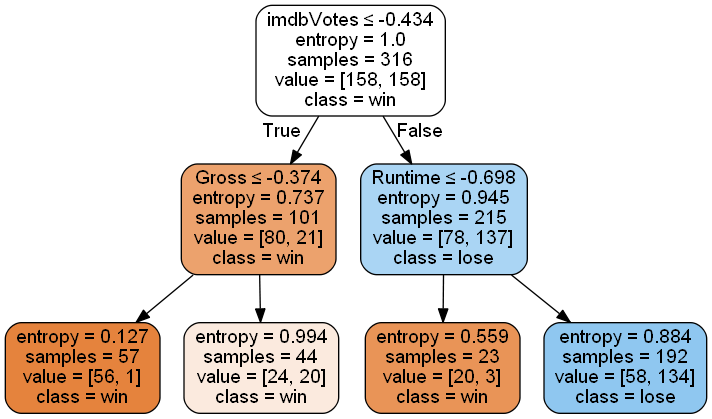

In [166]:
dot_data = StringIO()

export_graphviz(DTC, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["win", "lose"],
                 feature_names=X_train.columns
              )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### plot 한글 패치

In [23]:
%matplotlib inline

import os
from matplotlib import font_manager as fm, rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl

In [24]:
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
mpl.rc('font', family=font_name)


### Decision Tree 특성 중요도 plot

In [25]:
def plot_feature_importances_final_best(model):
    plt.figure(figsize=(9, 9))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

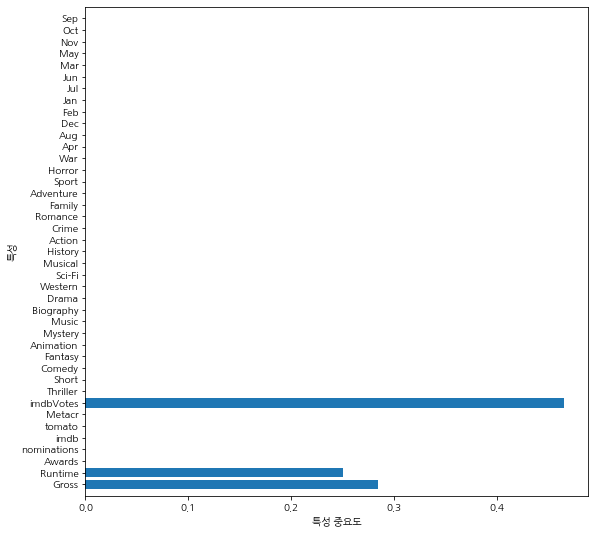

In [167]:
plot_feature_importances_final_best(DTC)

### 앙상블(emsemble)
앙상블이란 여러 개의 결정 트리(Decision Tree)를 결합하여 하나의 결정 트리보다 더 좋은 성능을 내는 머신러닝 기법이다.  
크게 3종류로 나눌 수 있다. 

* Bagging
* Boosting
* Voting

Bagging : Bagging은 Bootstrap Aggregation의 약자. 배깅은 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregration)하는 방법. RandomForest

Boosting : 가중치를 활용하여 약 분류기를 강 분류기로 만드는 방법. 

<img src = "./img/bagging_and_boosting.png">

출처: swallow.github.io

### GBC(GradientBoostingClassifier)

여러개의 Decision Tree를 묶어 강력한 모델을 만드는 기법.
이전 tree의 오차를 보완하는 방식으로 tree를 만든다. 

* learning_rate를 높이면 보정을 강하게 하기 때문에 복잡한 모델을 만든다.
* n_estimator 값을 키우면 ensemble에 트리가 더 많이 추가되어 모델의 복잡도가 커지고 train 세트를 더 정확하게 fitting한다.(오버피팅 주의)
* 기본값: max_depth=3, learning_rate=0.1

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [182]:
GBC = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
GBC.fit(X_train_over, y_train_over)

pred_GBC= GBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.4615


array([[44,  9],
       [ 5,  6]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [180]:
GB = GradientBoostingClassifier(random_state =1234)
parameters = {
    "max_depth" :[4],
    "learning_rate" :[0.55,0.5,0.45],
    "n_estimators" :[100]
   
    
    
}

grid_gb = GridSearchCV(GB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1 )
grid_gb.fit(X_train_over, y_train_over)

pred = grid_gb.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.4615


array([[44,  9],
       [ 5,  6]], dtype=int64)

In [181]:
grid_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### GBC 특성 중요도 Plot

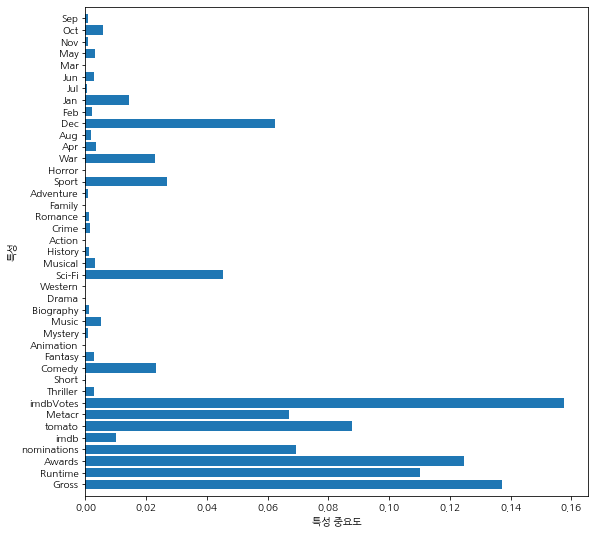

In [183]:
plot_feature_importances_final_best(GBC)

### XGBC(XGBClassifier)

Gradient Boosting(경사하강법)의 단점을 보완한 부스터   
CART(Classification and Regresstion Tree)기반 : Addictive learning = 더해서 배운다. 분류와 회귀 둘다 가능하다. 

일반 파라미터 : 도구 모양을 결정하는 파라미터. linear or tree
* booster : ['gbtree', 'gblinear', 'dart']
* nthread
* num_feature

부스팅 파라미터 : 트리마다 가지를 칠 때 적용하는 옵션. 선택한 booster마다 파라미터가 다름 

학습과정 파라미터 : 최적화 퍼포먼스를 결정하는 파라미터 

커맨드라인 파라미터 : epoch랑 비슷 

#### 파라미터 최적화 
- learning_rate, default = 0.3, 0~1 사이, 학습 단계별로 가중치를 얼만큼 줄까를 결정. 낮을수록 보수적
- gamma : min split loss, default = 0, 0~무한대 사이, 의사결정나무가 가지를 칠때 타켓변수에 대해 얼마나 설명할수 있나. 클수록 보수적, 가지를 안치려고 함
- max_depth : default = 6, 0~무한대.

xgboost 파라미터 :
https://xgboost.readthedocs.io/en/latest/parameter.html
https://apple-rbox.tistory.com/6

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier

In [177]:
XGBC = XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) 
                     

XGBC.fit(X_train_over, y_train_over)

pred_XGBC= XGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5600


array([[46,  7],
       [ 4,  7]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [175]:
XGB = XGBClassifier(random_state =1234, n_jobs=-1)
parameters = {
    "n_estimators" :[100,50,150, 200,250,300],
    "base_score" :[0.5, 0.1, 1],
    "booster":['gbtree'],
    "learning_rate" : [0.1,0.5,0.01,0.001],
    "max_depth" :[3,4,5,6,7,8]
}

grid_xgb = GridSearchCV(XGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_xgb.fit(X_train_over, y_train_over)

pred = grid_xgb.predict(X_test)

print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 score : 0.5600


array([[46,  7],
       [ 4,  7]], dtype=int64)

In [176]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### XGBoostClassifier 특성 중요도 plot

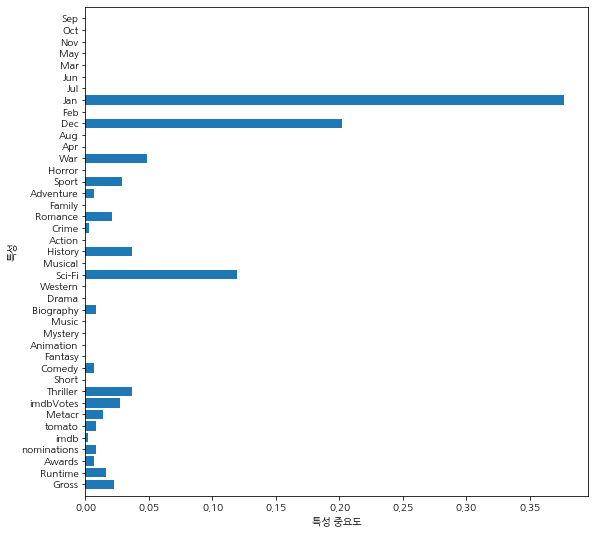

In [178]:
plot_feature_importances_final_best(XGBC)

### Light GBMC(light gradient boosting machine)
XGBoost의 느린 단점을 보완하기 위해 나옴

다른 Booster의 트리는 level-wise(균형 중심)분할을 이용. depth를 줄이고 균형을 맞춤.
lightgbm은 leaf-wise(리프 중심)분할. 균형을 맞추지 않고 계속 분할. 비대칭적이고 깊은 트리, 동일한 leaf를 생성할 때 level-wise보다 손실이 적다.

파라미터 튜닝 : https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [37]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [174]:
LGBC = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBC.fit(X_train_over, y_train_over)

pred_LGBC = LGBC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5600


array([[46,  7],
       [ 4,  7]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [172]:
LGB =LGBMClassifier(random_state =1234, n_jobs=-1)
parameters = {
    "n_estimators" :[100],
   "learning_rate":[0.1,0.15, 0.05, 0.01],
    "num_leaves" : [31],
    "min_child_samples" : [20]
}
grid_lgb = GridSearchCV(LGB,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lgb.fit(X_train_over, y_train_over)

pred = grid_lgb.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.5600


array([[46,  7],
       [ 4,  7]], dtype=int64)

In [173]:
grid_lgb.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### LGBMClassifier 특성 중요도 plot

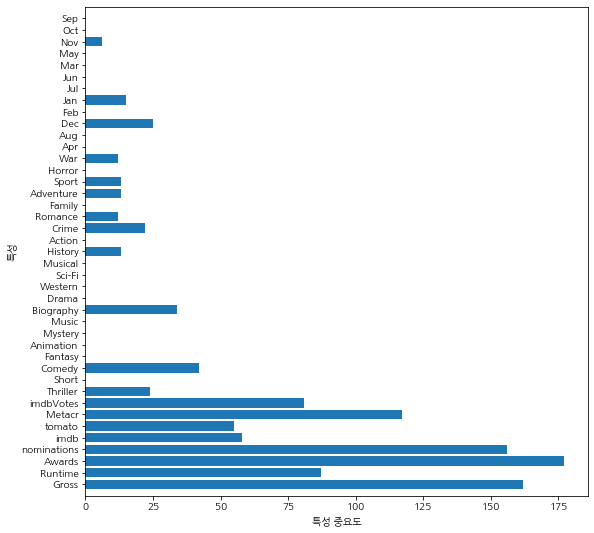

In [142]:
plot_feature_importances_final_best(LGBC)

### RFC(RandomForestClassifier)
여러 개의 의사결정나무를 만들고, 그들의 다수결로 결과를 결정하는 방법
classification 과 regression 에 모두 쓸 수 있다.  

- N-estimator : 랜덤포레스트 안에 만들어지는 의사결정나무 갯수. 트리가 많아지면 속도가 느려지고 너무 트리가 크면 오히려 정확도가 낮아진다. 그러나 일반적으론 트리가 많아질수록 분류를 잘하게 되므로 적절한 trade-off 필요하다.

- Max-depth : 랜덤포레스트 안에 있는 각 의사결정나무의 깊이를 설정. 트리가 깊어질수록 더 잘게 분류를 시키므로 일반적으론 정확도가 높아진다.

- Min-samples-split : 내부 노드에 데이터를 얼마 만큼씩 최소한 넣을 것인가 설정. 10%~100%로 설정. 100%로 갈수록 underffiting이 일어나서 정확도가 낮아진다. 

- Min-samples-leaf : 리프 노드에 데이터를 얼마 만큼씩 최소한 넣을 것인가 설정. 10%~100%로 설정. 100%로 갈수록 underffiting이 일어나서 정확도가 낮아진다.

- Max-feature : 가장 잘 분류할 feature의 갯수를 설정. 



In [42]:
from sklearn.ensemble import RandomForestClassifier

In [146]:
RFC =RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

RFC.fit(X_train_over, y_train_over)

pred_RFC = RFC.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.4800


array([[45,  8],
       [ 5,  6]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [144]:
RF =RandomForestClassifier(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,25,30],
    "min_samples_leaf" : [1,2,3,4,5],
    "min_samples_split" : [2,3,4,5],
    "max_features" : [20,30,40,50]
  
}
grid_rf = GridSearchCV(RF,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_rf.fit(X_train_over, y_train_over)

pred = grid_rf.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.4800


array([[45,  8],
       [ 5,  6]], dtype=int64)

In [145]:
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=30,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

### RFC 특성 중요도 Plot

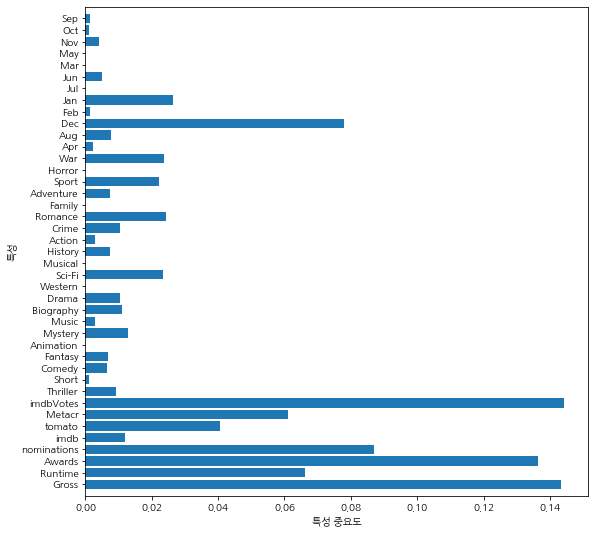

In [147]:
plot_feature_importances_final_best(RFC)

### 특성 중요도 top 7으로만 RFC 돌리기

In [47]:
df = pd.DataFrame()
df['import']= grid_rf.best_estimator_.feature_importances_
df['ft']  = X_train_over.columns
df.sort_values('import', ascending=False, inplace = True)
df.reset_index(inplace=True)
df

,index,import,ft
0,7,0.144189,imdbVotes
1,0,0.143456,Gross
2,2,0.136522,Awards
3,3,0.086964,nominations
4,31,0.078023,Dec
5,1,0.066215,Runtime
6,6,0.061106,Metacr
7,5,0.040645,tomato
8,33,0.026444,Jan
9,23,0.024276,Romance


In [152]:
RFC1 =RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

RFC1.fit(X_train_over[list(df.loc[:7,'ft'])], y_train_over)

pred_RFC1 = RFC1.predict(X_test[list(df.loc[:7,'ft'])])

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)

f1 Score : 0.3077


array([[42, 11],
       [ 7,  4]], dtype=int64)

In [150]:
RF =RandomForestClassifier(random_state =1234, n_jobs=-1)

parameters = {
    "n_estimators" :[10,20,30,40],
    "min_samples_leaf" : [1,2,3,4,5,6],
    "min_samples_split" : [2,3,4,5,6],
   "max_features" :[8]
  
}
grid_rf1 = GridSearchCV(RF,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)

grid_rf1.fit(X_train_over[list(df.loc[:7,'ft'])], y_train_over)

pred = grid_rf1.predict(X_test[list(df.loc[:7,'ft'])])

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)


f1 Score : 0.3077


array([[42, 11],
       [ 7,  4]], dtype=int64)

In [151]:
grid_rf1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

f1 Score가 0.48 -> 0.3226 로 변화하였다.    
max_feature의 값이 줄어들면서 분류 성능이 낮아졌다. 

### LogisticRegression
* 범주형 변수를 예측하는 회귀모델 
* odds(승산) = 발생할 확률 / 발생하지 않을 확률 = p / (1-p)
* log Odds ratio
* 로짓변환 : y -> log(y/1-y) =log(Odds) = c + ax
* sigmoid 함수 
* "독립변수 X에 대한 선형 회귀식을 X가 주어졌을 때의 반응 변수 Y의 로그 오즈에 적합시킨다."
* "편의(bias)가 없는 타당한 계수 추정치를 계산할 수 있다." -> 불균형한 데이터를 오버샘플링하면 모집단과 특성이 달라지는데 이러면 수치가 달라짐. 로지스틱 회귀는 계수추정치는 변하지 않고 절편만 바뀜. = 편의 없이 계수 추정치를 구하는 방법이다. 


In [51]:
from sklearn.linear_model import LogisticRegression

In [156]:
LRC = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=1234, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
LRC.fit(X_train_over, y_train_over)
pred_LRC = LRC.predict(X_test)
print("f1 score : {0:.4f}".format(f1_score(y_test,pred)))
confusion_matrix(y_test,pred)

f1 score : 0.3571


array([[41, 12],
       [ 6,  5]], dtype=int64)

### GridSearchCV로 최적의 파라미터 찾기

In [154]:
LR =LogisticRegression(random_state =1234, n_jobs=-1)

parameters = {
     "penalty" : ['l1', 'l2', 'elasticnet', 'none'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  
}
grid_lr = GridSearchCV(LR,
                         param_grid=parameters,
                         scoring="f1",
                         cv=skf,
                        n_jobs=-1)
grid_lr.fit(X_train_over, y_train_over)

pred = grid_lr.predict(X_test)

print("f1 Score : {0:.4f}".format(f1_score(y_test,pred)))

confusion_matrix(y_test,pred)



f1 Score : 0.3571


array([[41, 12],
       [ 6,  5]], dtype=int64)

In [155]:
grid_lr.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=1234, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

### votingClassifier

* hard voting: 단순 투표. 개별 모형의 결과 기준
* soft voting: 가중치 투표. 개별 모형의 조건부 확률의 합 기준    
#  
* estimators: 개별 모형 목록, 리스트나 named parameter 형식으로 입력
* voting: 문자열 {hard, soft} hard voting 과 soft voting 선택. 디폴트는 hard
* weights: 사용자 가중치 리스트

In [57]:
from sklearn.ensemble import VotingClassifier

In [238]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC)], voting='hard')

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Hard Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[DTC, GBC,XGBC,LGBC,RFC, LRC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Hard Voting 분류기 f1 score: 0.6154
DecisionTreeClassifier f1 score :  0.3636
GradientBoostingClassifier f1 score :  0.4615
XGBClassifier f1 score :  0.5600
LGBMClassifier f1 score :  0.5600
RandomForestClassifier f1 score :  0.4800
LogisticRegression f1 score :  0.3571


hard voting에서 좋은 성능을 위해 좋은 성능을 내는 모델들만 이용하여 hard voting을 할 수 있다.  
이 경우에는 빼면 성능이 나빠져서 모두 넣었다. 

In [189]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC)], voting='soft')

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Soft Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Soft Voting 분류기 f1 score: 0.5600
DecisionTreeClassifier f1 score :  0.3636
GradientBoostingClassifier f1 score :  0.4615
XGBClassifier f1 score :  0.5600
LGBMClassifier f1 score :  0.5600
RandomForestClassifier f1 score :  0.4800
LogisticRegression f1 score :  0.3571


In [256]:
vo_clf = VotingClassifier(estimators=[('DTC', DTC),('GBC', GBC),('XGBC', XGBC), ('LGBC', LGBC ), ('RFC', RFC), ('LRC', LRC)], voting='soft', weights=[1,2,2,2,2,1])

vo_clf.fit(X_train_over,y_train_over)
pred = vo_clf.predict(X_test)
print('Soft-weighted Voting 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

Soft-weighted Voting 분류기 f1 score: 0.5833
DecisionTreeClassifier f1 score :  0.3636
GradientBoostingClassifier f1 score :  0.4615
XGBClassifier f1 score :  0.5600
LGBMClassifier f1 score :  0.5600
RandomForestClassifier f1 score :  0.4800
LogisticRegression f1 score :  0.3571


soft voting 보다 모델에게 가중치를 준 soft-weighted 성능이 더 좋다.

### EnsembleVoteClassifier을 이용하여 voting
VotingClassifier, hard로 한거랑 값이 같다

In [117]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import model_selection

In [191]:


eclf = EnsembleVoteClassifier(clfs=[ DTC, GBC,XGBC, LGBC , RFC, LRC], weights=[1,2,2,2,2,1])

eclf.fit(X_train_over,y_train_over)
pred = eclf.predict(X_test)
print('EnsembleVoteClassifier 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

classifiers =[ DTC, GBC,XGBC,LGBC,RFC, LRC]
for classifier in classifiers:
    classifier.fit(X_train_over, y_train_over)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} f1 score : {1: .4f}'.format(class_name, f1_score(y_test,pred)))

EnsembleVoteClassifier 분류기 f1 score: 0.6154
DecisionTreeClassifier f1 score :  0.3636
GradientBoostingClassifier f1 score :  0.4615
XGBClassifier f1 score :  0.5600
LGBMClassifier f1 score :  0.5600
RandomForestClassifier f1 score :  0.4800
LogisticRegression f1 score :  0.3571


### baggingClassifirer

* 부트스트랩 어그리게이팅 Bootstrap AGGregING의 약어
* 데이터양이 적으면 성능이 안좋다. 
* 대표적인 bagging 앙상블 = RandomForest. 위에서 랜포 성능이 안좋았던걸 기억하면..... 안좋음  
* Note that using larger subsamples is not guaranteed to improve your results. In bagging there is a tradeoff between base model accuracy and the gain you get through bagging. The aggregation from bagging may improve the ensemble greatly when you have an unstable model, yet when your base models are more stable — been trained on larger subsamples with higher accuracy — improvements from bagging reduces.  
#
* base_estimator: 기본 모형
* n_estimators: 모형 갯수. 디폴트 10
* bootstrap: 데이터의 중복 사용 여부. 디폴트 True
* max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율. 디폴트 1.0
* bootstrap_features: 특징 차원의 중복 사용 여부. 디폴트 False
* max_features: 다차원 독립 변수 중 선택할 차원의 수 혹은 비율 1.0

In [59]:
from sklearn.ensemble import BaggingClassifier

In [239]:
bag_clf = BaggingClassifier(base_estimator=vo_clf, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('voting Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

voting Bagging 분류기 f1 score: 0.3810


In [240]:
bag_clf = BaggingClassifier(base_estimator=GBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('GBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

GBC Bagging 분류기 f1 score: 0.4444


In [241]:
bag_clf = BaggingClassifier(base_estimator=XGBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('XGBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

XGBC Bagging 분류기 f1 score: 0.5185


In [242]:
bag_clf = BaggingClassifier(base_estimator=LGBC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('LGBC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

LGBC Bagging 분류기 f1 score: 0.4800


In [243]:
bag_clf = BaggingClassifier(base_estimator=RFC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('RFC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

RFC Bagging 분류기 f1 score: 0.3636


In [244]:
bag_clf = BaggingClassifier(base_estimator=LRC, n_estimators=10, random_state=0)

bag_clf.fit(X_train_over,y_train_over)
pred = bag_clf.predict(X_test)
print('LRC Bagging 분류기 f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

LRC Bagging 분류기 f1 score: 0.3448


### stacking

* 모델에서 나온 예측값을 하나의 데이터 프레임으로 만들어 다시한번 모델에 넣어 예측한다. 
* 각 모델에서 나온 pred 들은 컬럼으로 생성됨. transpose로 row로 변경해서 데이터 프레임 모양을 맞춰줘야한다. 

In [227]:
X_test.shape

(64, 41)

In [201]:
df_stacking = np.array([pred_DTC, pred_GBC, pred_XGBC, pred_LGBC, pred_RFC, pred_LRC])
df_stacking.shape

(6, 64)

In [202]:
df_stacking = np.transpose(df_stacking)
df_stacking.shape

(64, 6)

In [250]:
XGBC_stacking = XGBClassifier()
XGBC_stacking.fit(df_stacking,y_test)
pred = XGBC_stacking.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.4706


In [205]:
XGBC.fit(df_stacking,y_test)
pred = XGBC.predict(df_stacking)
print('stacking with XGBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with XGBC f1 score: 0.6316


XGBC로 stacking할때 f1 score가  votingClassifier로 hard voting할 때보다 약간 성능이 좋아짐을 알 수 있다.  
0.6154 -> 0.6316

In [251]:
GBC_stacking = GradientBoostingClassifier()
GBC_stacking.fit(df_stacking,y_test)
pred = GBC_stacking.predict(df_stacking)
print('stacking with GBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with GBC f1 score: 0.6316


In [252]:
GBC.fit(df_stacking,y_test)
pred = GBC.predict(df_stacking)
print('stacking with GBC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with GBC f1 score: 0.6316


In [246]:
RFC_stacking = RandomForestClassifier()
RFC_stacking.fit(df_stacking,y_test)
pred = RFC_stacking.predict(df_stacking)
print('stacking with RFC_stacking f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with RFC_stacking f1 score: 0.6316


위에서 만든 RFC 모델은 feature갯수를 지정해놔서 사용하면 에러가 발생함.

In [248]:
LRC_stacking = LogisticRegression()
LRC_stacking.fit(df_stacking,y_test)
pred = LRC_stacking.predict(df_stacking)
print('stacking with LRC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with LRC f1 score: 0.2667


In [254]:
LRC.fit(df_stacking,y_test)
pred = LRC.predict(df_stacking)
print('stacking with LRC f1 score: {0:.4f}'.format(f1_score(y_test,pred)))

stacking with LRC f1 score: 0.2667
